# Расчет траектории

## Библиотеки

### Установка библиотек

In [4]:
!pip install numpy matplotlib scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.0 MB/s eta 0:00:00


### Импорт библиотек

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Параметры

Реальные параметры

In [3]:
# config = {
#     'G': 6.6743e-11,
#     'Venus_r': 6051.8e3,
#     'Venus_mass': 4.867e24,
#     'Probe_mass': 5600e3,
#     'v0': 11.8e3,
#     'h0': 248e3,
#     'time_range': 3600,
#     'time_step': 1e-4,
#     'method': 'RK45'
# }

Параметры для KSP

In [1]:
config = {
    'G': 6.6743e-11,
    'Venus_r': 700e3,
    'Venus_mass': 1.2243980e23,
    'Probe_mass': 5600e3,
    'v0': 4.086e3,
    'h0': 248e3,
    'time_range': 3600,
    'time_step': 1e-4,
    'method': 'RK45'
}

## Метод Эллера

Нам нужно решить дифференциальное уравнение второго порядка:
$$\bold{\ddot{r}}=-\frac{G(M+m)}{r^3}\bold{r}$$
Где $\bold{\ddot{r}}$ - вторая производная по времени от радиус вектора $\bold{r}$ ($\bold{\ddot{r}}=\frac{d}{dt}(\frac{d\bold{r}}{dt})$)

Для этого воспользуемся методом Эллера

In [4]:
def dr_dt(t, y):
    """
    Решение дифференциального уравнения второго прядка для нахождения скорости и координаты аппарата.
    :param y: y[:3] - позиция, y[3:] - скорость
    :param t: время
    :return: 
    """
    mu = config['G'] * config['Venus_mass']
    r = np.linalg.norm(y[:3])
    dr = y[3:]
    dv = - (mu / (r ** 3)) * y[:3]
    dy = np.concatenate([dr, dv])
    return dy

В качестве начальной позиции возьмем из [данных по полету](https://pds-atmospheres.nmsu.edu/data_and_services/atmospheres_data/Cassini_PDS3/mission-cat_3-26-13) минимальную высоту над венерой и скорость в этот момент. Назовем данный момент T0.

In [5]:
v0 = np.array([0, config['v0'], 0], dtype=np.float64)
r0 = np.array([config['h0'] + config['Venus_r'], 0, 0], dtype=np.float64)
y0 = np.concatenate([r0, v0])

Для начала посчитаем координату и скорость до T0 и выведем график координату

In [6]:
t_minus_eval = np.arange(0, -config['time_range'], -config['time_step'])

y_minus = solve_ivp(dr_dt, [0, -config['time_range']], y0, t_eval=t_minus_eval, method=config['method'], vectorized=True).y

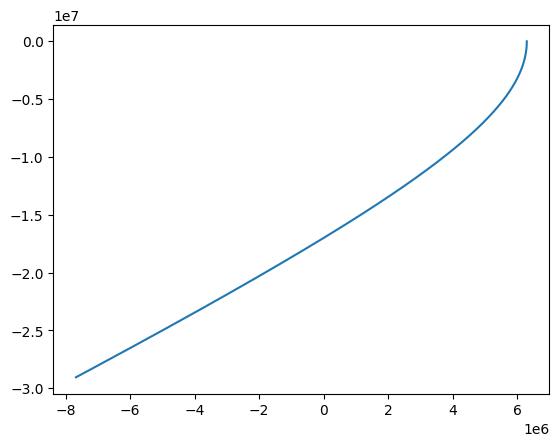

In [7]:
plt.plot(y_minus[0], y_minus[1])

plt.show()

Тоже самое сделаем для скорости и координаты после T0

In [8]:
t_plus_eval = np.arange(0, config['time_range'], config['time_step'])

y_plus = solve_ivp(dr_dt, [0, config['time_range']], y0, t_eval=t_plus_eval, method=config['method'], vectorized=True).y

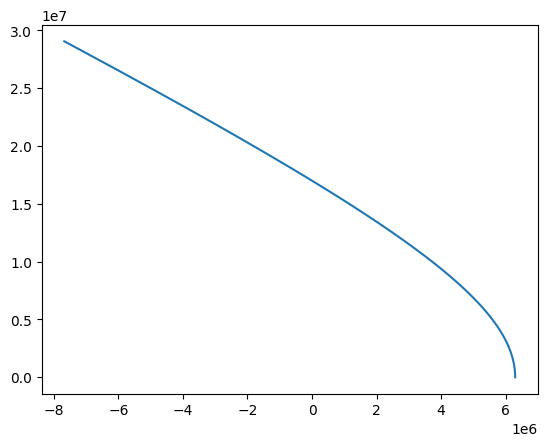

In [9]:
plt.plot(y_plus[0], y_plus[1])

plt.show()

## Итоговые графики
Теперь объединим все данные и выведем 3d график

In [10]:
y = np.concatenate([np.flip(y_minus, axis=1), y_plus[:, 1:]], axis=1)

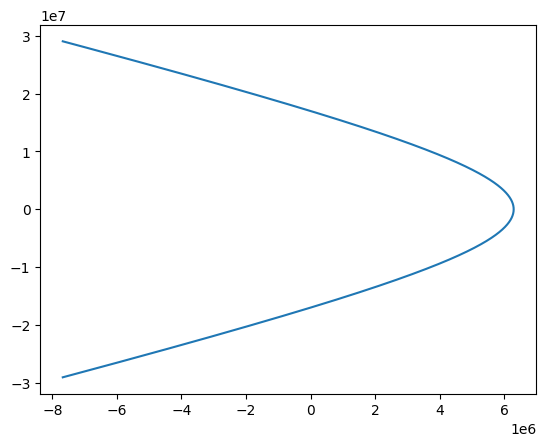

In [11]:
plt.plot(y[0], y[1])

plt.show()

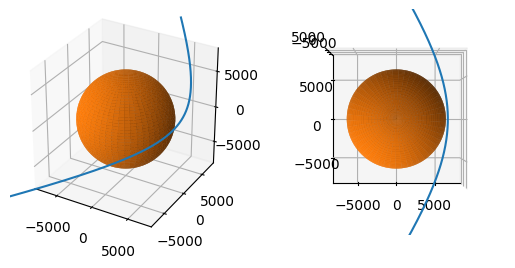

In [12]:
fig = plt.figure(dpi=100)


def make_plot(position, elev, azim, roll):
    ax = fig.add_subplot(position, projection='3d')

    ax.view_init(elev=elev, azim=azim, roll=roll)

    # Настройка масштаба 
    axis_max = config['Venus_r'] / 1000 * 1.3
    ax.axes.set_xlim3d(left=-axis_max, right=axis_max)
    ax.axes.set_ylim3d(bottom=-axis_max, top=axis_max)
    ax.axes.set_zlim3d(bottom=-axis_max, top=axis_max)

    # График сферы
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    planet_x = config['Venus_r'] * np.outer(np.cos(u), np.sin(v))
    planet_y = config['Venus_r'] * np.outer(np.sin(u), np.sin(v))
    planet_z = config['Venus_r'] * np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot(y[0] / 1000, y[1] / 1000, y[2] / 1000, label='Орбита', zorder=10)
    ax.plot_surface(planet_x / 1000, planet_y / 1000, planet_z / 1000, zorder=1)

    ax.set_aspect('equal')


make_plot(121, None, None, None)
make_plot(122, 90, -90, 0)

plt.show()

Выведем график модуля скорости от времени

In [13]:
v = np.linalg.norm(y[3:], axis=0) / 1000

In [14]:
t = np.concatenate([np.flip(t_minus_eval, axis=0), t_plus_eval[1:]]) / 60

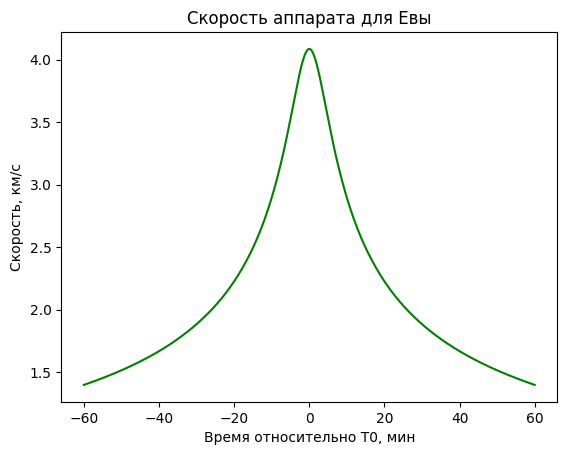

In [20]:
plt.plot(t, v, 'g')
plt.title("Скорость аппарата для Евы")
plt.ylabel("Скорость, км/с")
plt.xlabel("Время относительно T0, мин")

plt.show()

Как мы видим график скорости очень похож на нормальное распределение

# Сохранение результатов

In [25]:
import joblib

joblib.dump(v, '../data/math_v.joblib')
joblib.dump(t, '../data/math_t.joblib')
joblib.dump(y, '../data/math_y.joblib')

['../data/math_y.joblib']